In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import shutil

# Set image dimensions for training
IMG_HEIGHT = 256
IMG_WIDTH = 256 

In [4]:
# Convert YOLO label format to binary mask
def yolo_to_mask(label_file, img_shape):
    mask = np.zeros((img_shape[0], img_shape[1]), dtype=np.uint8)
    if os.path.exists(label_file):
        with open(label_file, 'r') as f:
            for line in f.readlines():
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                x_center *= img_shape[1]
                y_center *= img_shape[0]
                width *= img_shape[1]
                height *= img_shape[0]
                x_min = int(x_center - width / 2)
                y_min = int(y_center - height / 2)
                x_max = int(x_center + width / 2)
                y_max = int(y_center + height / 2)
                mask[y_min:y_max, x_min:x_max] = 1
    return mask

In [5]:
# Load dataset with YOLO labels
def load_yolo_dataset(image_dir, label_dir):
    images, masks = [], []
    for filename in os.listdir(image_dir):
        if filename.endswith(('.jpg', '.png')):
            img_path = os.path.join(image_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            img = img / 255.0
            images.append(img)
            
            label_filename = filename.replace('.jpg', '.txt').replace('.png', '.txt')
            label_path = os.path.join(label_dir, label_filename)
            mask = yolo_to_mask(label_path, (IMG_HEIGHT, IMG_WIDTH))
            masks.append(mask)
    images = np.array(images)
    masks = np.array(masks)
    masks = np.expand_dims(masks, axis=-1)
    return images, masks

In [6]:
# Data generator
def data_generator(image_dir, label_dir, batch_size):
    image_filenames = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    while True:
        np.random.shuffle(image_filenames)
        for start in range(0, len(image_filenames), batch_size):
            end = min(start + batch_size, len(image_filenames))
            batch_filenames = image_filenames[start:end]
            batch_images, batch_masks = [], []
            for filename in batch_filenames:
                img_path = os.path.join(image_dir, filename)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                img = img / 255.0
                batch_images.append(img)
                
                label_filename = filename.replace('.jpg', '.txt').replace('.png', '.txt')
                label_path = os.path.join(label_dir, label_filename)
                mask = yolo_to_mask(label_path, (IMG_HEIGHT, IMG_WIDTH))
                batch_masks.append(mask)
            yield np.array(batch_images), np.expand_dims(np.array(batch_masks), axis=-1)

In [5]:
# Dice and Binary Cross-Entropy combined loss
from tensorflow.keras.losses import Loss
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable(package='custom')
def dice_bce_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    bce_loss = bce(y_true, y_pred)
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice_loss = 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return 0.5 * bce_loss + 0.5 * dice_loss

# Define ResNet block
def resnet_block(inputs, filters):
    if inputs.shape[-1] != filters:
        inputs = layers.Conv2D(filters, (1, 1), padding='same')(inputs)
    x = layers.Conv2D(filters, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, inputs])
    x = layers.ReLU()(x)
    return x

# Create ResNet-UNet model
def create_deeper_resnet_unet(input_shape):
    inputs = layers.Input(shape=input_shape)
    c1 = resnet_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = resnet_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    c3 = resnet_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    c4 = resnet_block(p3, 512)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    c5 = resnet_block(p4, 1024)
    p5 = layers.MaxPooling2D((2, 2))(c5)
    bottleneck = resnet_block(p5, 2048)
    u5 = layers.Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(bottleneck)
    u5 = layers.concatenate([u5, c5])
    c6 = resnet_block(u5, 1024)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c6)
    u6 = layers.concatenate([u6, c4])
    c7 = resnet_block(u6, 512)
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c7)
    u7 = layers.concatenate([u7, c3])
    c8 = resnet_block(u7, 256)
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c8)
    u8 = layers.concatenate([u8, c2])
    c9 = resnet_block(u8, 128)
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c9)
    u9 = layers.concatenate([u9, c1])
    c10 = resnet_block(u9, 64)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c10)
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Learning rate schedule
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    elif 10 <= epoch < 20:
        return lr * 0.1
    else:
        return lr * 0.01

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',        # Metric to monitor
    factor=0.5,                # Factor by which the learning rate will be reduced
    patience=3,                # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,                 # To see updates
    min_lr=1e-6                # Lower bound on the learning rate (it won’t decrease below this value)
)

In [6]:

import tensorflow as tf

def dice_coefficient(y_true, y_pred):
    # Ensure both y_true and y_pred are of type float32
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))  # Cast y_true to float32
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))  # Cast y_pred to float32
    
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)  # Element-wise multiplication
    
    # Dice coefficient formula
    return (2. * intersection + 1e-7) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-7)



def precision(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))  # Cast to float32
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))  # Cast to float32
    true_positives = tf.keras.backend.sum(y_true_f * y_pred_f)
    predicted_positives = tf.keras.backend.sum(y_pred_f)
    return true_positives / (predicted_positives + 1e-7)

def recall(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))  # Cast to float32
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))  # Cast to float32
    true_positives = tf.keras.backend.sum(y_true_f * y_pred_f)
    possible_positives = tf.keras.backend.sum(y_true_f)
    return true_positives / (possible_positives + 1e-7)

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + 1e-7)



In [7]:
# Main execution
if __name__ == "__main__":
    train_image_dir = '/kaggle/input/dataset-lunar-crater/LU3M6TGT_yolo_format/train/images'
    train_label_dir = '/kaggle/input/dataset-lunar-crater/LU3M6TGT_yolo_format/train/labels'
    valid_image_dir = '/kaggle/input/dataset-lunar-crater/LU3M6TGT_yolo_format/valid/images'
    valid_label_dir = '/kaggle/input/dataset-lunar-crater/LU3M6TGT_yolo_format/valid/labels'
    ##bacth size(original-32) modified to 16
    epochs = 25
    batch_size = 16
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
    model = create_deeper_resnet_unet(input_shape)
    
    initial_lr = 1e-3
    
    model.compile(optimizer=AdamW(learning_rate=initial_lr),
                  loss=dice_bce_loss,
                  metrics=['accuracy', f1_score, precision, recall, dice_coefficient])

    train_gen = data_generator(train_image_dir, train_label_dir, batch_size)
    val_gen = data_generator(valid_image_dir, valid_label_dir, batch_size)

    num_train_samples = len(os.listdir(train_image_dir))
    num_val_samples = len(os.listdir(valid_image_dir))
    steps_per_epoch = num_train_samples // batch_size
    validation_steps = num_val_samples // batch_size
    
    lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

    # Define where to save the model
    model_save_path = "model_checkpoint.keras"

    # Model checkpoint callback to save the best model
    model_checkpoint = ModelCheckpoint(
        filepath=model_save_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    # Include the callbacks
    # removinig lr_scheduler from callbacks and adding reduce_lr_on_plateau
    callbacks = [early_stopping, reduce_lr, model_checkpoint]

    # Training the model
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=callbacks
    )
   

Epoch 1/25


I0000 00:00:1741036728.919343      99 service.cc:145] XLA service 0x78c1f8004880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741036728.919442      99 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1741036759.595468      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.8590 - dice_coefficient: 0.5055 - f1_score: 0.5055 - loss: 0.4108 - precision: 0.4796 - recall: 0.5469
Epoch 1: val_loss improved from inf to 0.38710, saving model to model_checkpoint.keras
539/539 ━━━━━━━━━━━━━━━━━━━━ 361s 584ms/step - accuracy: 0.8590 - dice_coefficient: 0.5057 - f1_score: 0.5057 - loss: 0.4107 - precision: 0.4797 - recall: 0.5470 - val_accuracy: 0.8941 - val_dice_coefficient: 0.5570 - val_f1_score: 0.5570 - val_loss: 0.3871 - val_precision: 0.6668 - val_recall: 0.4816 - learning_rate: 0.0010
Epoch 2/25
539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.9087 - dice_coefficient: 0.6605 - f1_score: 0.6605 - loss: 0.2870 - precision: 0.6590 - recall: 0.6711
Epoch 2: val_loss did not improve from 0.38710
539/539 ━━━━━━━━━━━━━━━━━━━━ 335s 580ms/step - accuracy: 0.9087 - dice_coefficient: 0.6606 - f1_score: 0.6606 - loss: 0.2869 - precision: 0.6590 - recall: 0.6711 - val_accuracy: 0.8885 - val_dice_coefficient:

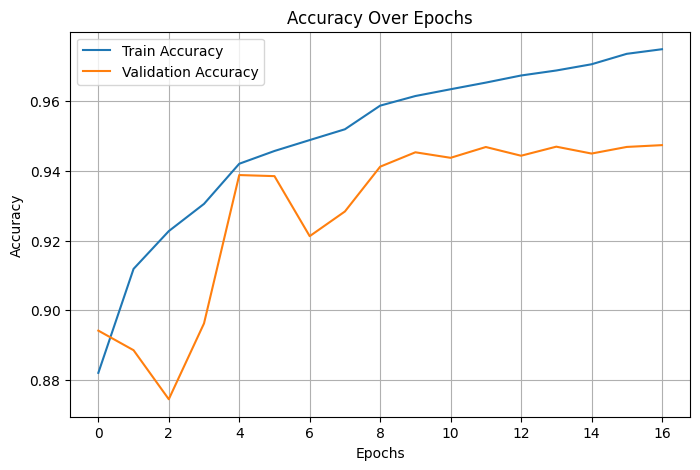

In [8]:
import matplotlib.pyplot as plt

# Define the metrics to plot
metrics = ['accuracy']
titles = ['Accuracy']

# Generate plots for each metric
for metric, title in zip(metrics, titles):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history[metric], label=f'Train {title}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {title}')
    plt.title(f'{title} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(title)
    plt.legend()
    plt.grid(True)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


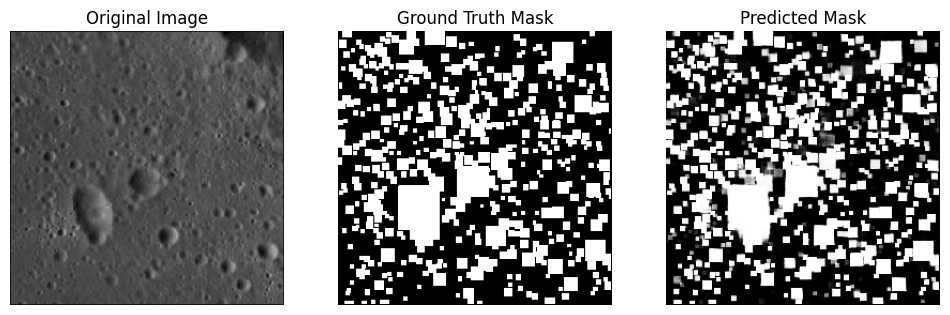

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


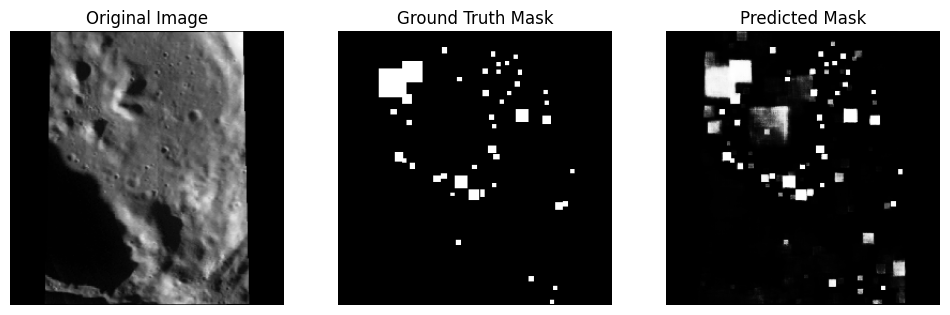

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


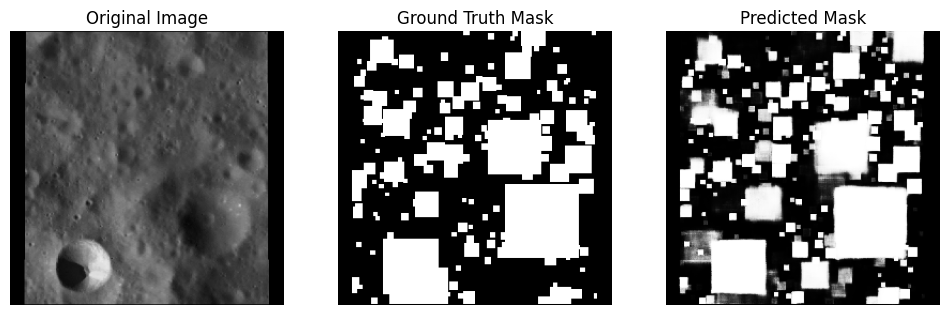

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


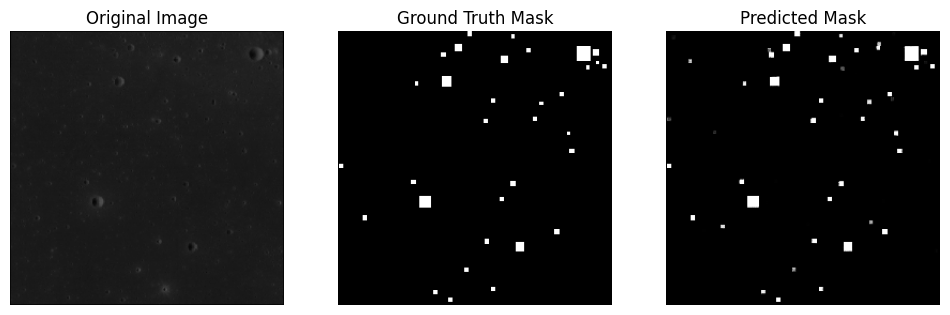

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


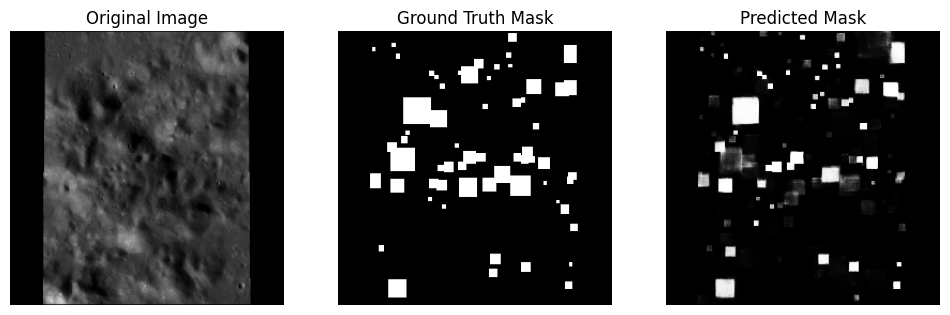

In [9]:
def visualize_predictions(model, image_dir, label_dir, num_samples=5):
    """
    Visualizes predictions by displaying the original image, ground truth mask, and predicted mask.

    Parameters:
    - model: Trained model.
    - image_dir: Directory containing images.
    - label_dir: Directory containing YOLO labels for masks.
    - num_samples: Number of samples to visualize.
    """
    image_filenames = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    selected_files = np.random.choice(image_filenames, num_samples, replace=False)

    for filename in selected_files:
        # Load and preprocess the image
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img_norm = img / 255.0  # Normalize
        img_input = np.expand_dims(img_norm, axis=0)

        # Predict the mask
        pred_mask = model.predict(img_input)[0].squeeze()  # Remove batch dimension

        # Load the ground truth mask
        label_filename = filename.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(label_dir, label_filename)
        true_mask = yolo_to_mask(label_path, (IMG_HEIGHT, IMG_WIDTH))

        # Plot results
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.show()

# Example usage
visualize_predictions(model, valid_image_dir, valid_label_dir, num_samples=5)


In [10]:
#saving the model

model.save(f'crater_detection_model{val_accuracy:.2f}.keras')

NameError: name 'val_accuracy' is not defined

In [1]:

from tensorflow.keras.models import load_model

def dice_bce_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    bce_loss = bce(y_true, y_pred)
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice_loss = 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return 0.5 * bce_loss + 0.5 * dice_loss

loaded_model = load_model('/kaggle/working/crater_detection_model95.keras', custom_objects = {"dice_bce_loss":dice_bce_loss})

loaded_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 256, 256,  │        256 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_34[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_22 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 256, 256,  │     36,928 │ re_lu_22[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_23 (ReLU)     │ (None, 256, 256,  │          0 │ add_11[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 128, 128,  │          0 │ re_lu_23[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 128, 128,  │      8,320 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_37[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_24 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 128, 128,  │    147,584 │ re_lu_24[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 128, 128,  │          0 │ batch_normalizat

 Total params: 427,779,525 (1.59 GB)

 Trainable params: 142,585,153 (543.92 MB)

 Non-trainable params: 24,064 (94.00 KB)

 Optimizer params: 285,170,308 (1.06 GB)

I0000 00:00:1741068176.369599      68 service.cc:145] XLA service 0x7a65a4026340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741068176.369671      68 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1741068179.013874      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


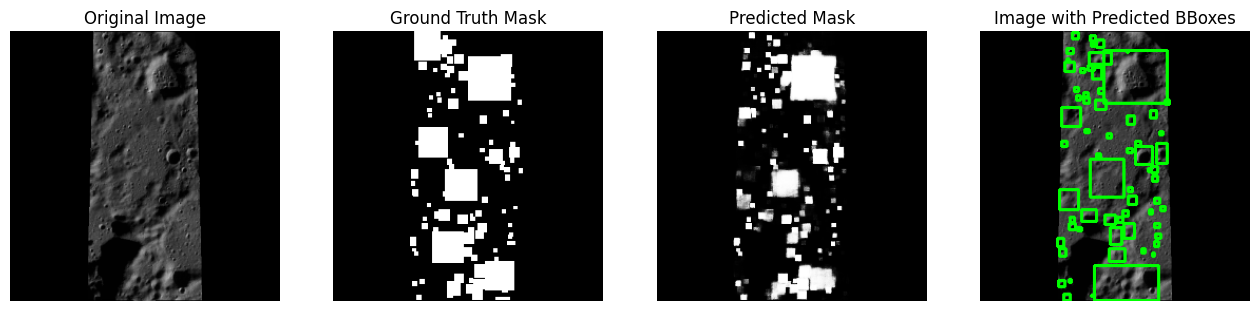

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


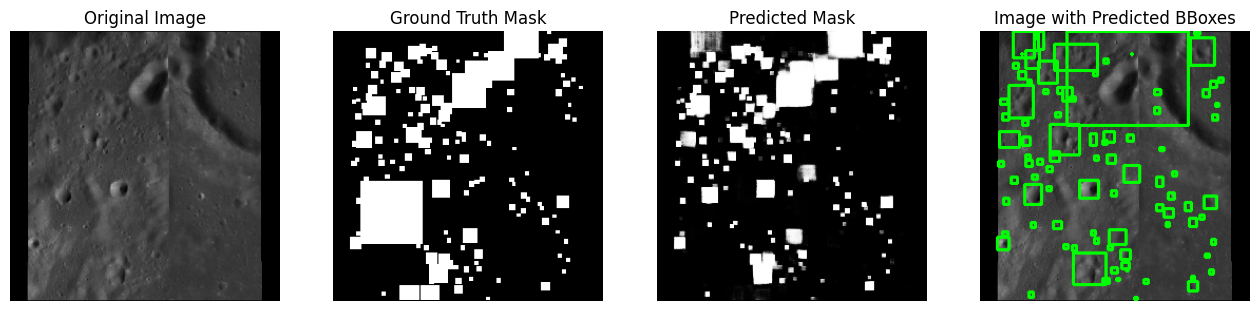

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


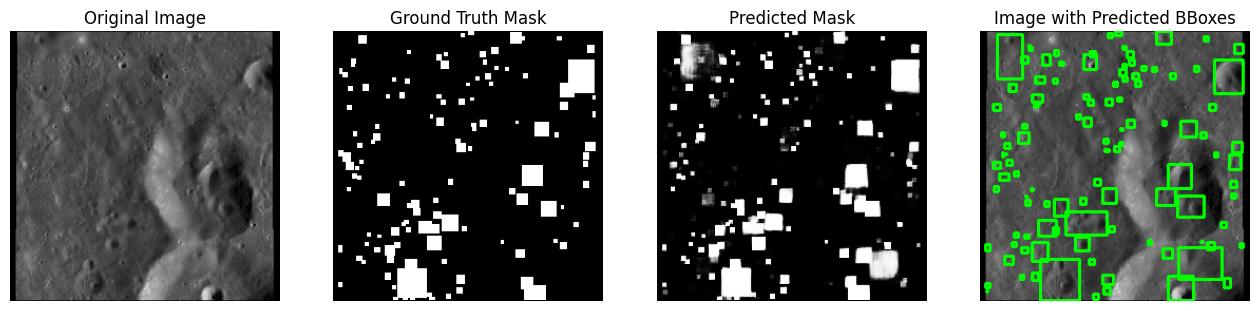

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


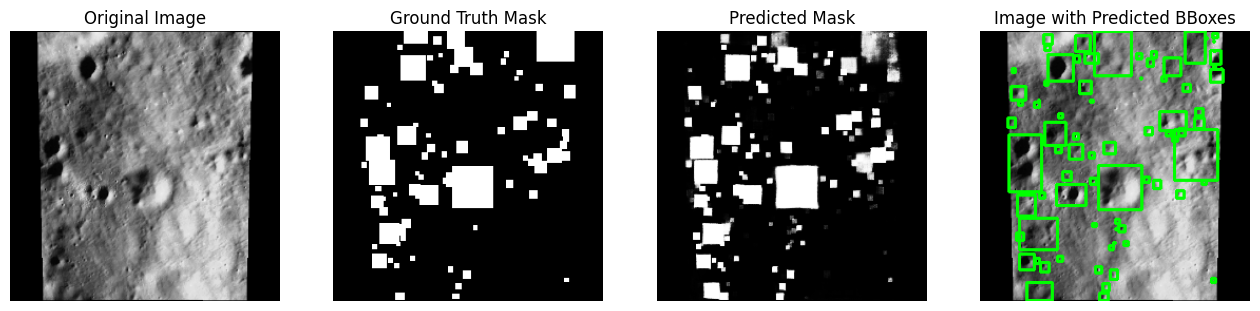

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


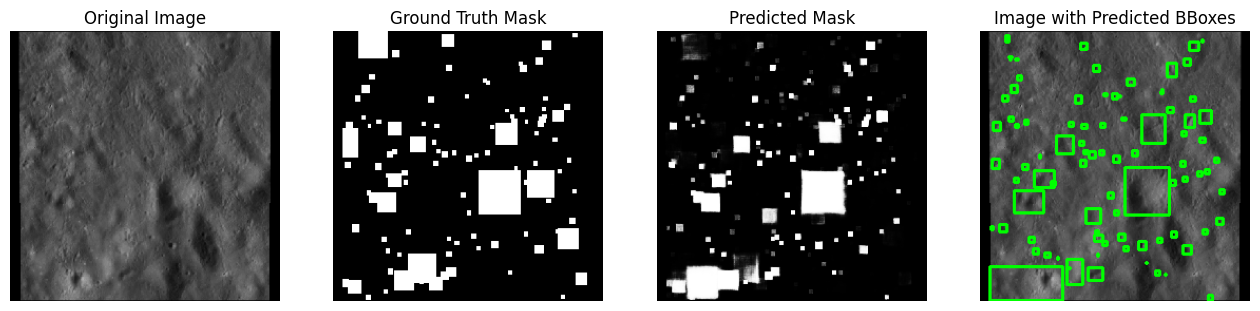

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


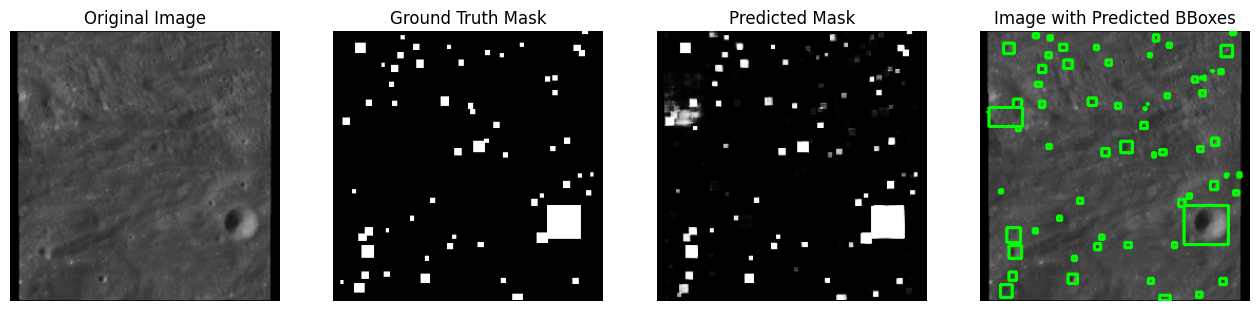

In [7]:
def visualize_predictions_with_bboxes(model, image_dir, label_dir, num_samples=5):
    """
    Visualizes predictions by displaying the original image with predicted bounding boxes, 
    ground truth mask, and predicted mask.

    Parameters:
    - model: Trained model.
    - image_dir: Directory containing images.
    - label_dir: Directory containing YOLO labels for masks.
    - num_samples: Number of samples to visualize.
    """
    image_filenames = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    selected_files = np.random.choice(image_filenames, num_samples, replace=False)

    for filename in selected_files:
        # Load and preprocess the image
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img_norm = img_resized / 255.0  # Normalize
        img_input = np.expand_dims(img_norm, axis=0)

        # Predict the mask
        pred_mask = model.predict(img_input)[0].squeeze()  # Remove batch dimension

        # Create bounding box from predicted mask
        pred_mask_binary = (pred_mask > 0.5).astype(np.uint8)
        contours, _ = cv2.findContours(pred_mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        bbox_img = img_resized.copy()

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(bbox_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Load the ground truth mask
        label_filename = filename.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(label_dir, label_filename)
        true_mask = yolo_to_mask(label_path, (IMG_HEIGHT, IMG_WIDTH))

        # Plot results
        plt.figure(figsize=(16, 4))

        plt.subplot(1, 4, 1)
        plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(cv2.cvtColor(bbox_img, cv2.COLOR_BGR2RGB))
        plt.title("Image with Predicted BBoxes")
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.show()

# Example usage
valid_image_dir = '/kaggle/input/dataset-lunar-crater/LU3M6TGT_yolo_format/valid/images'
valid_label_dir = '/kaggle/input/dataset-lunar-crater/LU3M6TGT_yolo_format/valid/labels'

visualize_predictions_with_bboxes(loaded_model, valid_image_dir, valid_label_dir, num_samples=6)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


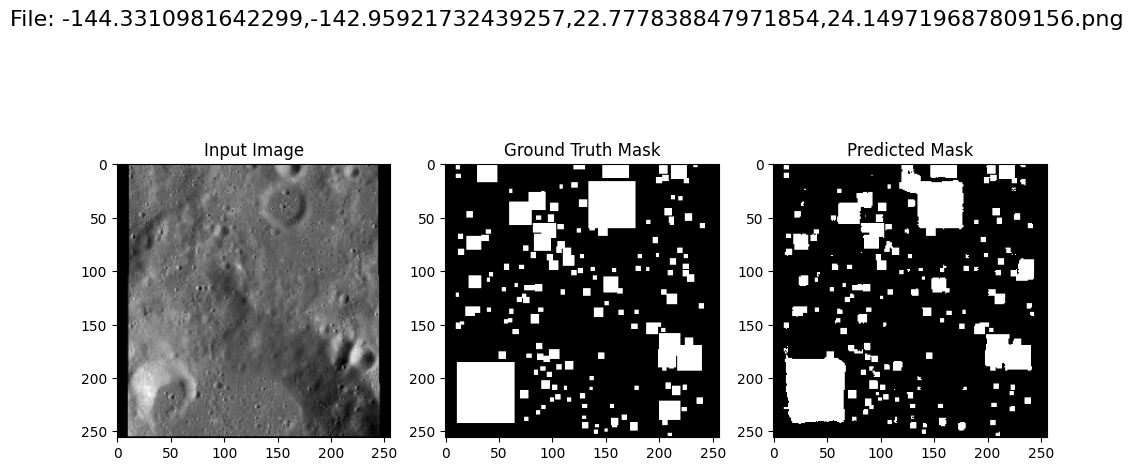

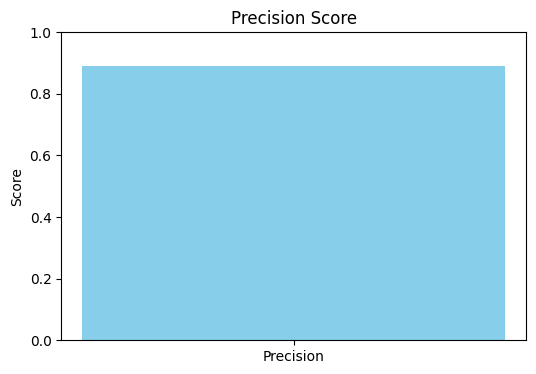

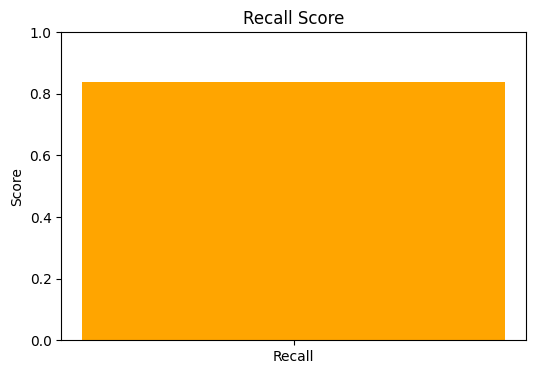

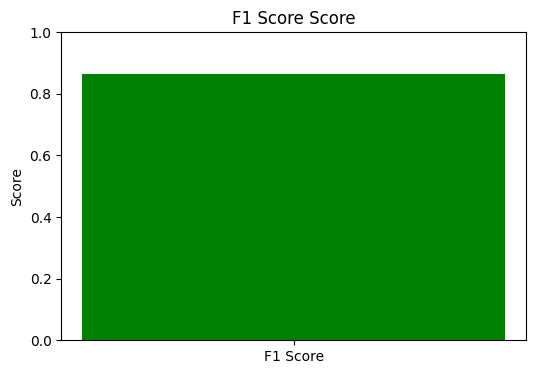

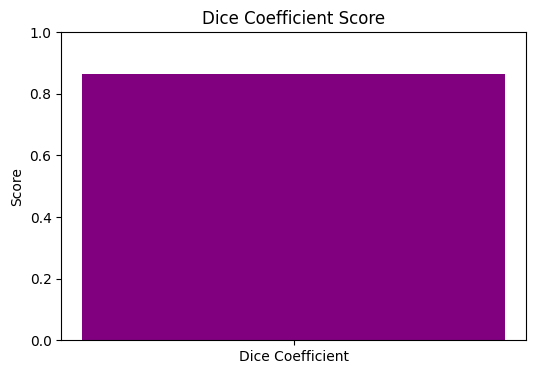

In [8]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to convert YOLO annotations to a binary mask
def yolo_to_mask(label_file, img_shape):
    mask = np.zeros((img_shape[0], img_shape[1]), dtype=np.uint8)
    if os.path.exists(label_file):
        with open(label_file, 'r') as f:
            for line in f.readlines():
                # Extract YOLO label details
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                # Convert normalized YOLO coordinates to pixel coordinates
                x_center *= img_shape[1]
                y_center *= img_shape[0]
                width *= img_shape[1]
                height *= img_shape[0]
                # Calculate bounding box
                x_min = int(x_center - width / 2)
                y_min = int(y_center - height / 2)
                x_max = int(x_center + width / 2)
                y_max = int(y_center + height / 2)
                # Fill mask for the bounding box
                mask[y_min:y_max, x_min:x_max] = 1
    return mask

# Function to load and process a random image and label
def load_random_image_label(image_folder, label_folder, img_shape):
    # List image and label files
    image_files = sorted(os.listdir(image_folder))
    label_files = sorted(os.listdir(label_folder))

    # Randomly select an image file
    random_index = random.randint(0, len(image_files) - 1)
    image_path = os.path.join(image_folder, image_files[random_index])
    label_path = os.path.join(label_folder, label_files[random_index])

    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    image = cv2.resize(image, (img_shape[1], img_shape[0]))  # Resize to match the mask shape

    # Convert the YOLO-style label to a mask
    mask = yolo_to_mask(label_path, img_shape)

    return image, mask, image_files[random_index]

# Dice coefficient function
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

# Paths to the image and label folders
image_folder = '/kaggle/input/dataset-lunar-crater/LU3M6TGT_yolo_format/valid/images'  # Replace with actual path
label_folder = '/kaggle/input/dataset-lunar-crater/LU3M6TGT_yolo_format/valid/labels'  # Replace with actual path
img_shape = (256, 256)  # Specify the desired image and mask shape (height, width)

# Load the trained model
model_path = "/kaggle/working/crater_detection_model95.keras"  # Update with your model's path
model = load_model(model_path, compile=False)

# Load a random image and label
image, label, selected_file = load_random_image_label(image_folder, label_folder, img_shape)

# Preprocess the image for the model
input_image = image.astype(np.float32) / 255.0  # Normalize to [0, 1]
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension
input_image = np.expand_dims(input_image, axis=-1)  # Add channel dimension (1 channel for grayscale)
input_image = np.repeat(input_image, 3, axis=-1)  # Convert to 3-channel by repeating grayscale channel

# Predict the mask
predicted_mask = model.predict(input_image)
predicted_mask = (predicted_mask[0, :, :, 0] > 0.5).astype(np.uint8)  # Threshold predictions

# Flatten arrays for metric calculations
flattened_true = label.flatten()
flattened_pred = predicted_mask.flatten()

# Calculate metrics
precision = precision_score(flattened_true, flattened_pred)
recall = recall_score(flattened_true, flattened_pred)
f1 = f1_score(flattened_true, flattened_pred)
dice = dice_coefficient(flattened_true, flattened_pred)

# Plot the random image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(label, cmap='gray')
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')

plt.suptitle(f'File: {selected_file}', fontsize=16)
plt.show()

# Plot each metric separately
def plot_metric(metric_name, metric_value, color):
    plt.figure(figsize=(6, 4))
    plt.bar([metric_name], [metric_value], color=color)
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title(f'{metric_name} Score')
    plt.show()

# Plot each metric
plot_metric('Precision', precision, 'skyblue')
plot_metric('Recall', recall, 'orange')
plot_metric('F1 Score', f1, 'green')
plot_metric('Dice Coefficient', dice, 'purple')